-0.34433285509325684
[[-0.0, 0.0], [0.0012686859714564692, 2.1421676329816692e-05], [0.009117087530724217, 0.0010935504362897944], [0.027560712916798777, 0.009675567693824001], [0.058693304756706983, 0.04093591986167883], [0.10423550203349648, 0.11365513763522196], [0.16703720219807877, 0.23832877544243206], [0.25113285286742393, 0.4070113669798277], [0.35948000501656, 0.5929886330201721], [0.4901612511126707, 0.7616712245575679], [0.6334035773770547, 0.8863448623647783], [0.7719931333258233, 0.9590640801383215], [0.8861103038932463, 0.9903244323061761], [0.9610653406443918, 0.9989064495637104], [0.9945111356272253, 0.9999785783236705]]


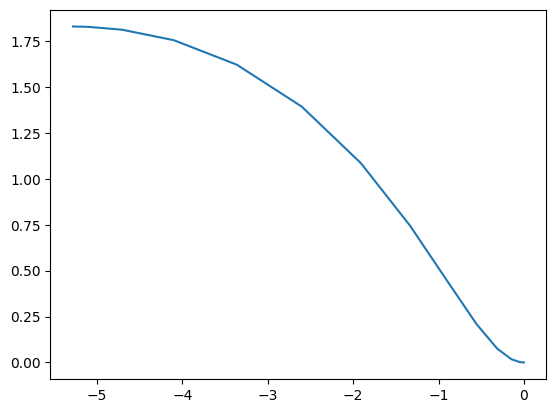

In [1]:
from scipy.optimize import minimize, least_squares
import numpy as np
import matplotlib.pyplot as plt
import math

"""
theta = the orientation of the cars frame in the world
phi = the steering angle
The configuration of the q = (x, y, theta, phi)
u1 = v_car or the linear speed of the car
u2 = phi_prime, the turning rate of the front wheel

q_prime = f(q, u1, u2)
x_prime = v_car * cos(theta) = u1 * cos(theta)
y_prime = v_car * sin(theta) = u1 * sin(theta)
phi_prime = u2
L = distance between rear and front axles
theta_prime = v_car * 1/L * tan(phi) = u1 * 1/L * tan(phi)
"""

def p(t, tf=10):
    return (10/tf**3) * t**3 - (15/tf**4) * t**4 + (6/tf**5) * t**5

# x(p) = a0 + a1 * p + a2 * p2^2 + a3 * p3^3
# y(p) = b0 + b1 * p + b2 * p2^2 + b3 * p3^3
def opt(p_out, x):
    x_der = (x[2] + 2 * x[3] * p_out + 3 * x[4] * p_out**2)**2
    y_der = (x[5] + 2 * x[6] * p_out + 3 * x[7] * p_out**2)**2
    return x_der**2 + y_der**2

def theta(p_out, x):
    x_der = (x[2] + 2 * x[3] * p_out + 3 * x[4] * p_out**2)**2
    y_der = (x[5] + 2 * x[6] * p_out + 3 * x[7] * p_out**2)**2
    return math.atan2(y_der, x_der)

start_x, start_y = 0, 0
end_x, end_y = 5.31114, 1.8288
start_theta, end_theta = 0, 0

x0 = [1, 1, 1.3, 0.7, 0.8, 1.9, 1.9, 1.2]
cons = (
    {'type': 'eq', 'fun': lambda x: x[0] - start_x},
    {'type': 'eq', 'fun': lambda x: x[4] - start_y},
    {'type': 'eq', 'fun': lambda x: x[5] - math.tan(math.radians(start_theta))},
    {'type': 'eq', 'fun': lambda x: x[0] + x[1] + x[2] + x[3] - end_x},
    {'type': 'eq', 'fun': lambda x: x[4] + x[5] + x[6] + x[7] - end_y},
    {'type': 'eq', 'fun': lambda x: x[5] + 2 * x[6] + 3 * x[7] - math.tan(math.radians(end_theta))}
    )
res = minimize(
    lambda x : opt(0, x), x0, tol=1e-6, constraints=cons
    )
B = res.x
xs = []
ys = []
"""
What do I need:
    1. I need to generate a path from start to end that considers the starting and ending thetas. Check
    2. The generated path is then used to
"""
points = []
num_points = 15
for i in range(num_points):
    p_out = p(i, tf=num_points)
    x = B[0] + B[1] * p_out + B[2] * p_out**2 + B[3] * p_out**3
    y = B[4] + B[5] * p_out + B[6] * p_out**2 + B[7] * p_out**3
    points.append([x / (end_x - start_x), y / (end_y - start_y)])
    xs.append(x)
    ys.append(y)
print((end_y - start_y) / (end_x - start_x))
print(points)
#print(math.degrees(theta(1, B)))
#rint(math.degrees(theta(0, B)))
plt.plot(xs, ys)
#print(res.x)


In [26]:
# Should ONLY be 3D points that have been seen in all the previous and current frames
def windowed_bundle_adjustment(pts_2d, pts_3d, cam_poses):
    def loss(current_pose: np.ndarray):
        error = 0
        er = lambda twod, threed, pose: np.sum((twod - (pose.dot(threed) / threed[2])[:2])**2)
        reshaped = current_pose.reshape((3, 4))
        for k in range(len(cam_poses) - 1):
            error += er(pts_2d[k][0], pts_3d[k][0], reshaped)
            error += er(pts_2d[k][1], pts_3d[k][1], reshaped)
            error += er(pts_2d[k][2], pts_3d[k][2], reshaped)
        # error += er(pts_2d[-1][0], pts_3d[-1][0], reshaped)
        # error += er(pts_2d[-1][1], pts_3d[-1][1], reshaped)
        # error += er(pts_2d[-1][2], pts_3d[-1][2], reshaped)
        return error
    return np.reshape(minimize(loss, cam_poses[-1].flatten()).x, (3, 4))

def create_3d_point3(camera_pose: np.ndarray):
    pts_2d, pts_3d = [], []
    for i in range(3):
        pt_3d = np.random.random((4,))
        pt_2d = (camera_pose.dot(pt_3d) / pt_3d[2])[:2] #+ np.random.random() * 2
        pts_2d.append(pt_2d)
        pts_3d.append(pt_3d)
    return pts_2d, pts_3d

first_pose = np.zeros((3, 4))
first_pose[0, 0] = 1
first_pose[1, 1] = 1
first_pose[2, 2] = 1
first_pose[2, 3] = 1
first_2d, first_3d = create_3d_point3(first_pose)
second_pose = np.zeros((3, 4))
second_pose[0, 0] = 1
second_pose[1, 1] = 1
second_pose[2, 2] = 1
second_pose[2, 3] = 1
second_pose[:, 3] += 10
second_2d, second_3d = create_3d_point3(second_pose)
print(f"Actual Projection Matrix:\n {second_pose}\n")
second_pose += np.random.random((3, 4)) * 0.1
print(f"Noisy Projection Matrix:\n {second_pose}\n")
res = windowed_bundle_adjustment([first_2d, second_2d], [first_3d, second_3d], [first_pose, second_pose])
print(f"Optimized Projection Matrix:\n {res}\n")


Actual Projection Matrix:
 [[ 1.  0.  0. 10.]
 [ 0.  1.  0. 10.]
 [ 0.  0.  1. 11.]]

Noisy Projection Matrix:
 [[1.00785993e+00 1.87709472e-02 3.14075516e-02 1.00642556e+01]
 [6.54531321e-02 1.09902441e+00 6.88818989e-03 1.00188949e+01]
 [8.16722473e-02 8.81792980e-02 1.00166019e+00 1.10795428e+01]]

Optimized Projection Matrix:
 [[-0.78373097 -1.14715875 -1.00358933  9.47609231]
 [-1.7725235  -0.1398736  -0.99739267  9.41643068]
 [ 0.08167225  0.0881793   1.00166019 11.07954284]]

